<style type="text/css">
.reveal {
font-size: 120%;
}</style>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact, Layout

epsilon = np.finfo(float).eps

# default size of figures generated in the Ipython notebook
plt.rcParams['figure.figsize'] = [14, 5]

### Spike train analysis using Python


####  <span style="color:LightSlateGray">Dr. Marcus Jeschke</span>

<img src="images/MJeschke_Neuroassembly_20210108.png" alt="File not found" >


<h3>Lehrprobe - Oldenburg W2-Neurobiologie des Hörens; 2.11.2021<h3>

##### . Intro: Reminder - What are spike trains?
- sequence of action potentials (or spikes) from neurons recorded electrically (via: pipettes/electrodes/electrode arrays) or optically (2PM)

###### From raw data to neuronal spike trains
<img src="images/Quiroga_PastPresentFutureSpikeSorting_Fig01.png" alt="From raw data recorded with metal electrodes to neuronal spike trains" width=50% style="margin-left:auto; margin-right:auto">
<div style="text-align: right;font-size:10pt">Rey et al. 2015 <em>Brain. Res. Bull</em> http://dx.doi.org/10.1016/j.brainresbull.2015.04.007)</div>

Neurons represent and transmit information by firing series of action potentials, i.e. spike trains

Only action potentials can be transmitted over larger distances other subthreshold fluctuations are severely attenuated and eventually die out. Action potentials on the other hand are regenerative processes and actively created.

We will not go into how to go from the actually recorded data to the spike trains – filtering, identification, sorting
SU vs. MU

##### The "central task" for the analysis of spike trains

- How does an animal/human make sense of the incoming spike trains to figure something out about the world in order to act?
- Animal cannot wait for a long time, cannot average (i.e. ask for repetitions of a stimulus or sensation).
- What properties of the spike trains tell us something about the world (i.e. stimuli)? Are some of them better or worse?

<img src="images/StimuliToNeuron.png" width=50% style="margin-left:auto; margin-right:auto">

<strong> So we want to understand something about the neural code. </strong>

**EXercise** ```test```


```From Dayan and Abbott: Neural encoding, the subject of chapters 1 and 2, refers to the map from stimulus to response. ```
We could measure the response of a neuron to a lot of different stimuli and predict how it would respond to other stimuli

```Neural decoding refers to the reverse map, from response to stimulus, and the challenge is to reconstruct a stimulus, or certain aspects of that stimulus, from the spike sequences it evokes.```

## Outline
- Firing rates
- Population rates
- Receptive fields
- Spike triggered averaging
- Describing neuronal variability: Fano Factor, Coefficient of variation
- convolution



##### Disclaimer

This lecture is prepared as an interactive Jupyter notebook.



The Python code shown is not a 'best practice' example of how to write Python code and functions. Rather, for readibility and conciseness I have not created proper doc strings, error handling etc.

In the Github repository, best practice examples are shown. 

https://owncloud.dpz.eu/index.php/s/UH9IrWReXPMoosR


The code also tries to avoid using external libraries as much as possible and instead generates code from first principles for illustrating concepts.

Notable libraries include:
- https://briansimulator.org/getting-started/ <img src="images/brian_logo_big.webp" width=120 style="margin-left:auto; margin-right:auto">
- https://elephant.readthedocs.io/en/latest/  <img src="images/elephant_logo_sidebar.png" width=120 style="margin-left:auto; margin-right:auto">
- https://pythonhosted.org/neuronpy/index.html 
    

https://elephant.readthedocs.io/en/latest/reference/statistics.html
    

##### Firing rates

spike train: $\{ t(i) \}$ stands for a number of spikes $n$ occuring at times $t(i)$ 

[0.2, 0.3, 0.35]

##### How to get from a spike train to a continuous function?

- useful to correlate spike train output to input

$$ \rho(t) = \sum_{i=1}^{n}{\delta(t - t_{i})} $$ with the <em>dirac delta</em> function 

$$ \delta \left( {t - t_{i}} \right) = 0,\,\,\,\,t \ne t_{i} $$

and

$$ \delta \left({t - t_{i}} \right) = +\infty,\,\,\,\,t = t_{i} $$

thus the integral of the  <em>dirac delta</em> function is one. The integral over $\rho(t)$ in a time window then gives the spike count in that window.


spike  trains typically denoted 

##### Spike train recorded after stimulation with xxxx

- spike trains differ between presentations: __there is "noise" in spike trains__
- thus a stimulus gets many different spike trains seemingly randomly

the noise leads to a probabilistic formulation of how spike trains correspond to events in the world (stimuli)


Post-stimulus time histogram (PSTH): count spikes in bin, normalize by number of repetitions
- gives firing rate or probability of firing per unit time (bin) as a function of time

<img src="images/StimuliToResponse.png" width=50% style="margin-left:auto; margin-right:auto">

averaging over stimuli, averaging over time
e.g. concatenating all relevant stimuli into a single time-dependent stimulus sequence

##### The spike-triggered average


<img src="images/DayanAbbot_TheoretNeuro_Fig1-8.png" width=45% style="margin-left:auto; margin-right:auto">
<div style="text-align: right;font-size:10pt">from Dayan & Abbott 2005 Theoretical Neuroscience. Fig. 1.8 </div>

<div style="text-align:center;"> Formula: $$ C(\tau) = \left\langle \frac{1}{n}  \sum_{i = 1}^{n} s(t_{i} - \tau) \right\rangle$$ </div>


In [85]:
def spike_triggered_average(spike_t, stimulus, dt, Tmin, Tmax):
    
    x = np.arange(Tmin, Tmax, dt)[::-1]*-1 # time vector for the stimulus average
    nBins_sta = x.shape[0]
    
    sta = np.zeros(nBins_sta) # prepare an array to contain the spike triggered average
    
    # loop through spikes, creating the average by first summing stimulus snippets and then
    # dividing by number of spikes used
    non_averaged_spikes = []
    for curSpike in spike_t:
         # is enough data of the stimulus available for the given spike?
            if (curSpike - Tmax >= 0 and curSpike - Tmin <= len(stimulus)*dt):
                start_bin = int(np.floor((curSpike - Tmax)/dt))

                sta = np.add(sta, stimulus[start_bin:start_bin + nBins_sta])
                #sta += stimulus[start_bin:start_bin + nBins_sta]
            else: # keep track of spikes that did not enter the averaging procedure
                non_averaged_spikes.append(curSpike)
                                
    # normalize by the number of spikes used for averaging                                
    sta = sta / (len(spike_t) - len(non_averaged_spikes))
                                
    return sta, x, non_averaged_spikes



    def spike_triggered_average(spike_t, stimulus, dt, Tmin, Tmax):
    """    
    Tmin, Tmax describe a window before a spike in which to look at the stimulus 
    dt is the sampling interval of the stimulus
    
    assumes that stimulus starts at time 0
    
    all are to be given in seconds
    """

###### Test our code with a mock example

Let us define a periodic signal (in this case a sinusoid) with some added noise. We will generate a neuron that fires at exactly the same phase of the periodic signal. If our spike triggered averaging code is correct we should recover the underlying sinusoid while averaging out the independent noise.

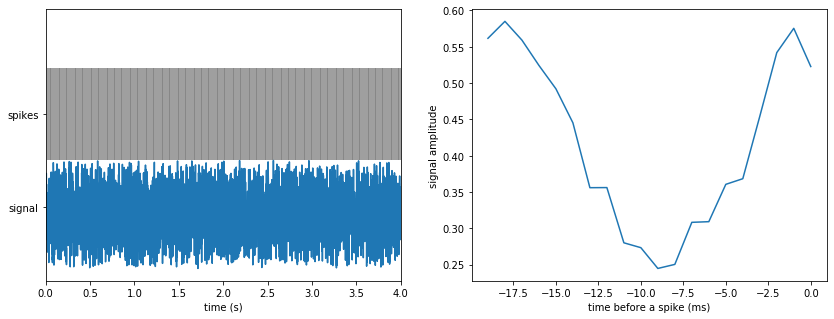

In [119]:
# test STA with a mock example
# generate sinusoidal signal plus noise
f = 50 # Hz
dt = 1/1000 # 1000 Hz sampling
dur = 4
t = np.arange(0,dur,dt)
signal = np.sin(2*np.pi*f*t) + np.random.rand(t.shape[0])*5 # sinusoid plus a much larger noise
signal *= 1/max(abs(signal)) # normalize for visualization
# generate a spike train always firing at period of sinusoid
spike_t = np.arange(0,dur,1/f) + 5/(f * 4)

# now check the spike triggered average
Tmin, Tmax = 0.0, 1/f # let us use one full period of the stimulus
sta, t_sta, non_averaged_spikes = spike_triggered_average(spike_t, signal, dt, Tmin, Tmax)

# visualize
h_fig, h_ax = plt.subplots(nrows = 1, ncols = 2)
h_ax[0].plot(np.arange(0, dur, dt), signal)
h_ax[0].eventplot(spike_t, lineoffsets = [1.5], color = 'gray')

h_ax[1].plot(t_sta * 1000, sta)

plt.setp(h_ax[0], xlim = [0, dur], yticks = [0.5, 1.5], yticklabels = ['signal', 'spikes'], xlabel = 'time (s)')
plt.setp(h_ax[1], xlabel = 'time before a spike (ms)', ylabel = 'signal amplitude')

plt.show()

Spike triggered averaging:
    
    https://github.com/abaybektursun/neural_encoding_H1

###### How to go from spike trains to know something about a potential stimulus?


- Joint distribution of spike trains and stimuli. Given by the probability of a stimulus given a spike train taking the likelihood of a spike train into account. $$ P[\{t_{i}\},s(t)] = P[s(t)|\{t_{i}\}] \times P[\{t{i}\}]   $$

$$ P[\{t{i}\}] $$ prior distribution of spike trains

- Link of stimuli given spike trains and spike trains given stimuli

$$ P[s(t)|\{t_{i}\}] \times P[\{t{i}\}] = P[\{t_{i}\}|s(t)] \times P[s(t)] $$

__Bayes' rule:__ $$ P[s(t)|\{t_{i}\} = P[\{t_{i}\}|s(t)] \times \frac{P[s(t)]}{P[\{t{i}\}]} $$

Bayes rule is bidirectional. While it is quite straightforward to fix a stimulus and present it multiple times, fixing a spike train and different samples of a stimulus. Spike triggered average gets to this idea fixing a single spike and looking at the stimulus with respect to this spike.

This is a test for speaker notes in RISE

##### Firing rates calculated from spike trains

Rieke_Spikes: first moment of the probability distribution of $P[\{t_{i}\},s(t)]$ is the mean spike count/rate per stimulus.


Spike rate of a single cell

\begin{equation}
{R}_i(t,T) = \frac{1}{T} \sum_{\tau=t}^{t+T} {S}_i(\tau) [spikes/s]
\end{equation}

Population spike rate
\begin{equation}
{R}_{pop}(t,T) = \frac{1}{C} \sum_{i=1}^{C}{R}_i(t,T) = \frac{1}{T \cdot C}\sum_{\tau = t}^{t+T} \sum_{i=1}^{C} {S}_i(\tau) [spikes/s]
\end{equation}

Average stimulus response
$$
\begin{equation}
{r}_i({\theta}_l,T) = \frac{1}{N({\theta}_l)} \sum_{n=1}^{N({\theta}_l)}{R}_i(t,T) = \frac{1}{N({\theta}_l)\cdot T} \sum_{n=1}^{N({\theta}_l)} \sum_{\tau=t}^{{t}_{l,n}+T}{S}_i(\tau) [spikes/s]
\end{equation}
$$


$$
\begin{align}
{r}_i({\theta}_l,T) = \frac{1}{N({\theta}_l)} \sum_{n=1}^{N({\theta}_l)}{R}_i(t,T) = \frac{1}{N({\theta}_l)\cdot T} \sum_{n=1}^{N({\theta}_l)} \sum_{\tau=t}^{{t}_{l,n}+T}{S}_i(\tau) &
[spikes/s]
\end{align}
$$


$$\begin{aligned} 2x - 4 &= 6 \\ 2x &= 10 \\ x &= 5 \end{aligned}$$

$$ 
\,dx \\
dx
$$

##### Current research example
<strong> Post-stimulatory activity in primate auditory cortex evoked by sensory stimulation during passive listening </strong>

<img src="images/Cooper_Bendor-PostStimActivity_Fig09.webp" style="margin-left:auto; margin-right:auto">
<div style="text-align: right;font-size:10pt">Cooper, Lee, Bartlett, Wang, Bendor (2020). Post-stimulatory activity in primate auditory cortex evoked by sensory stimulation during passive listening. <em>Sci. Rep</em> https://doi.org/10.1038/s41598-020-70397-0; Figure 09</div>

we have a discrete version of the <em>dirac delta</em> function for this:

which is one at the spike time bin and zero elsewhere.


##### Convolution


* Example: convolution of 2 rectangular functions $f(t)$ and $h(t)$ resulting in the convolved function $g(t)$

$$
\begin{align*}
f(t) &= \operatorname{rect}\left(0.5 . t\right) \\
h(t) &= \operatorname{rect}\left(0.5 . t\right) \\
\\
g(t) &= f(t) \ast h(t)
\end{align*}
$$

<img src="images/convolution.gif" width=480  style="margin-left:auto; margin-right:auto">

###### Gaussian kernel for convolution

Gaussian function: $$ {g}(x) = \frac{1}{\sigma\sqrt{2\pi}} \operatorname{exp}\left({{{ -\frac{1}{2} \frac{\left( {x - \mu } \right)^2}{\sigma^2} }}}\right) $$

In [2]:
def gaussian_kernel(sigma, mu, bandwidth, dt, Tmin, Tmax):
    
    x = np.arange(Tmin, Tmax+dt, dt) 
    
    x1 = sigma * np.sqrt(2 * np.pi)
    x2 = np.exp(-(x - mu)**2/(2 * sigma**2))
    gaussian_filter = (1/x1)*x2

    bandwidth_x = np.all((x > -bandwidth/2-epsilon, x <= bandwidth/2+epsilon),0)
    gaussian_kernel = gaussian_filter[bandwidth_x] 
    
    return gaussian_kernel, x[bandwidth_x]

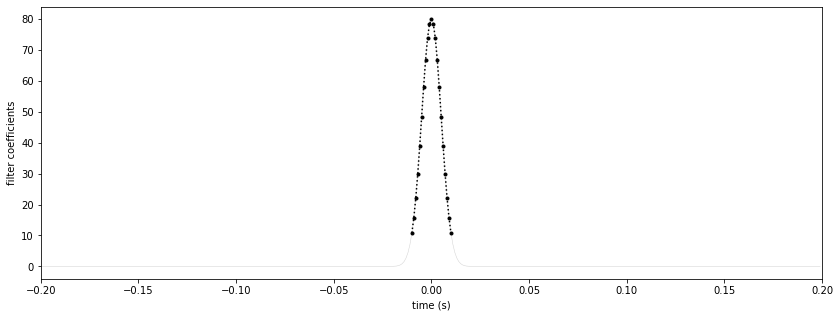

In [3]:
# Variables
sigma = 0.005
bandwidth = 0.020
mu = 0

Tmin, Tmax = -0.20, 0.20
binsize = 0.001

# Calculation
gaussian_filter, x = gaussian_kernel(sigma, mu, Tmax*2, binsize, Tmin, Tmax)

gauss_kern, gauss_x = gaussian_kernel(sigma, mu, bandwidth, binsize, Tmin, Tmax)

# Plotting
plt.plot(x, gaussian_filter, linewidth=0.5, color='lightgray')
plt.plot(gauss_x, gauss_kern, ':', marker='.', color = 'black')

ax = plt.gca()
ax.set_xlabel('time (s)')
ax.set_ylabel('filter coefficients')
ax.set_xlim(Tmin, Tmax)
plt.show()

##### The autocorrelation of a spike train

Interspike interval distributions are based on time between successive spikes.

spike-train autocorrelation function extends this idea to <strong> ANY </strong> two spikes. 
Useful to detect patterns in spike trains, i.e. oscillations.

take poisson process generated spike train to calculate the <em> ACF </em>

 $P[\{t_{i}\},s(t)]$ 
Rieke_Spikes: characterizing the distribution of P(rate/stim) or $P[\{t_{i}\},s(t)]$  can give the mean of the distribution (first moment of distribution).
Another way to characterize would be to look at the variance. This is related to joint probability of 2 spikes.

Joint probability of 2 spikes irrespective of anything in between: <strong> correlation function </strong>
correlation often normalized by firing rate to give probability of observing spike at $t + \Delta t$ given a spike at $t$

Autocorrelation function can be thought of (when normalized) as the firing rate at time $t + \Delta t$ given a spike at $t$



question: are neurons sensitive to higher order statistics of spike trains?

Yes, of course: remember integration of EPSPs to generate an action potential
Combination of the integration time and the noise level of the neuron

In [4]:
def autocorr(spike_t, binsize, max_t, normed = True):
    # calculate an estimate of the autocorrelation of an input spike train
    
    xbin_edges = np.arange(-max_t-binsize/2, max_t+binsize, binsize) # last bin includes the edge
    ac = np.zeros(len(xbin_edges)-1)
     
    for iSpk in range(len(spike_t)):
     
       relative_spike_t = spike_t - spike_t[iSpk]
     
       ac = ac + np.histogram(relative_spike_t, bins = xbin_edges)[0] # note that hist() puts all spikes outside the bin centers in the first and last bins! delete later.
     
    xbin = xbin_edges # remove unwanted bins
    ac = ac

    if normed:
        ac = ac/max(ac) # normalize
    
    return ac, xbin

##### A model of real spike trains: Poisson spike train

simple model of spike firing statistics.

Definition of a Poisson process: occurence of a spike occurs with some probability per unit time (rate). The rate can be time dependent but independent of occurence of other spikes.

How to recognize a <em>Poisson</em> process? 
check for time interval $0$ to $T$

Average number of spikes $\langle N \rangle$ is time integral of the firing rate: $\langle N\rangle = \int_{0}^{T}dt\,r(t)$

Variance of spike count is equal to the mean!

<strong><em>Fano factor</em></strong> describes the relationship of variance to the mean: $$ F = \frac{\sigma^2_{N}}{\langle N\rangle} = 1 $$

- Homogeneous poisson process: instantaneous firing rate is constant over time
    
    Thus the spike count in a time interval $\Delta t$ becomes: $$\langle N\rangle = r\Delta t$$
    The variance then in the time interval $\Delta t$ becomes: $$\sigma^2_{N} = r\Delta t$$
    
    What is the probability of observing 1 spike within a small time window? $P(1\,in\, \Delta t) = r\Delta T$
    if $\Delta t$ is very small, i.e. when $r\Delta t\ll 1$.


How this set of slides is supposed to work:
    
    1. explain what a point process and the special case of the poisson process (specifically poisson process) is
    2. write down the formula for the poisson process and related factors (mean, variance, fano factor)
    3. generate code to create poisson process based spike trains
    4. test with code whether the formula are correct

In [5]:
   def poissonSpikeTrain(rate, dt, timeInterval, seed = 10):
    # generate a homogenous Poisson spike train given rate [Hz] and timestep [s]

    tvec = np.arange(timeInterval[0], timeInterval[1], dt) # vector of timestamps
    
    pspike = rate * dt # probability of generating a spike in bin/timestep
    np.random.seed(seed) # reset random number generator to reproducible state
    spk_poiss = np.random.rand(len(tvec)) # random numbers between 0 and 1
    spk_poiss_idx = spk_poiss < pspike # boolean array of bins with spike
    spk_poiss_t = tvec[spk_poiss_idx] # use boolean indexing to get corresponding spike time
    
    return spk_poiss_t
    

Problem with poisson spike train using the method as described in def poissonSpikeTrain of assigning spikes to small bins is that it is discretized and not a continuous time value. Further, the procedure works if $\Delta t$ is very small, i.e. when $r\Delta t\ll 1$.
Second procedure is to choose interspike intervals randomly from the exponential distribution. Then each next spike is given by time of previous spike plus the randomly chosen interspike interval.
Practically though it is more convenient to discretely sample the spike train then making this procedure equivalent.

In [6]:
def poissonSpikeTrainISI(rate, timeInterval, seed = 10):
    """ generate a homogenous Poisson spike train given rate [Hz] and timestep [s] 
    by randomly selecting interspike intervals from exponential distribution.
    """
    def _ISI(rate):
        return -np.log(1.0 - np.random.rand()) / rate
    
    np.random.seed(seed) # reset random number generator to reproducible state
    
    spk_poiss_t = [timeInterval[0] + _ISI(rate)] # first spike 
    
    while spk_poiss_t[-1] <= timeInterval[1]:
        spk_poiss_t.append(spk_poiss_t[-1] + _ISI(rate)) # create the next spike by adding the ISI to the last spike
        
    return spk_poiss_t[:-1:] # the full spike train without the first spike time outside of the time interval
    

In [ ]:
def poissonSpikeTrainISI(rate, timeInterval, seed = 10):
    """ generate a inhomogenous Poisson spike train given rate over time and timestep [s] 
    by randomly selecting interspike intervals from exponential distribution.
    """
    def _ISI(rate):
        return -np.log(1.0 - np.random.rand()) / rate
    
    np.random.seed(seed) # reset random number generator to reproducible state
    
    spk_poiss_t = [timeInterval[0] + _ISI(rate)] # first spike 
    
    while spk_poiss_t[-1] <= timeInterval[1]:
        spk_poiss_t.append(spk_poiss_t[-1] + _ISI(rate)) # create the next spike by adding the ISI to the last spike
        
    return spk_poiss_t[:-1:] # the full spike train without the first spike time outside of the time interval
    

 52 spikes generated in 10 s


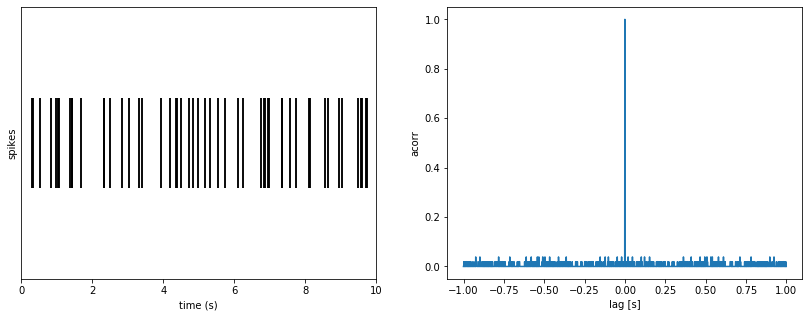

In [7]:
dt = 0.001   # time step in seconds
t  = [0, 10] # time interval (length) of spike train to generate   

# generate a poisson spike train
rate = 4.7 # in Hz
spk_poiss_t = poissonSpikeTrainISI(rate, t)
print(f" {len(spk_poiss_t)} spikes generated in {np.diff(t)[0]} s")

# poisson spike train auto correlation function
bin_size = 0.001 # in s
max_t    = 1 # in s
ac_poiss, bin_edges = autocorr(spk_poiss_t, bin_size, max_t) # calculate the autocorrelation function


# Plot the data
h_fig, h_ax = plt.subplots(ncols = 2, nrows = 1)
h_ax[0].vlines([spk_poiss_t, spk_poiss_t],-1, -0.5, Color = [0, 0, 0]) # note, plots all spikes in one command
h_ax[0].set_ylim([-1.5, 0])
h_ax[0].set_xlim([0, 10])
h_ax[0].set_yticks([])
h_ax[0].set_ylabel('spikes')
h_ax[0].set_xlabel('time (s)')

h_ax[1].plot(bin_edges[:-1]-bin_size/2, ac_poiss)


h_ax[1].set_xlabel('lag [s]')
h_ax[1].set_ylabel('acorr')

plt.show()

Renewal Processes (From David Heegers PDF)
It is possible to go beyond the Poisson model by allowing the firing probability to depend on both:
(1) the instantaneous firing rate, and (2) the time since the most recent previous spike (but not
on spike times before the most recent one). This results in a model of spike generation called a
renewal process.
A simple way to generate a renewal process spike train is to start with a Poisson spike train and
delete all but every th spike. An example is shown in Fig. 1F. This results in a spike train whose
interspike intervals are given by the gamma probability density function:
p() = (r)

􀀀1
e
􀀀r
=( 􀀀 1)!; (9)
where  (an integer) is called the order of the gamma distribution. When  is one, p( ) becomes
the exponential; the interval distribution expected of a Poisson process. When  is infinity, p( ) is
the distribution of no variance and the spike train is perfectly regular. The mean interspike interval
is
h i = 1=r for the gamma distribution, just as it is for the Poisson distribution. However, the
interspike interval standard deviation of the gamma distribution is different,
 = h i
p
;
so that the coefficient of variation of the gamma distribution is given by:
CV =

h i
=
1
p

 58 spikes generated in 10 s


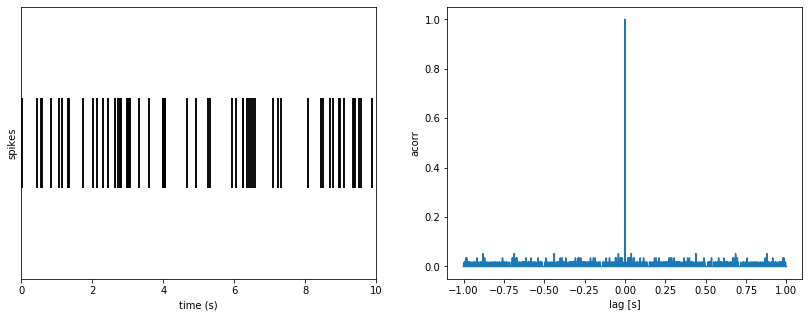

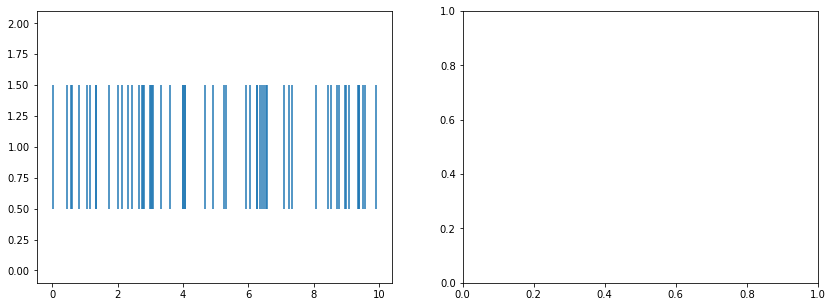

In [8]:
dt = 0.001   # time step in seconds
t  = [0, 10] # time interval (length) of spike train to generate   

# generate a poisson spike train
rate = 4.7 # in Hz
spk_poiss_t = poissonSpikeTrain(rate, dt, t)
print(f" {len(spk_poiss_t)} spikes generated in {np.diff(t)[0]} s")

# poisson spike train auto correlation function
bin_size = 0.001 # in s
max_t    = 1 # in s
ac_poiss, bin_edges = autocorr(spk_poiss_t, bin_size, max_t) # calculate the autocorrelation function


# Plot the data
h_fig, h_ax = plt.subplots(ncols = 2, nrows = 1)
h_ax[0].vlines([spk_poiss_t, spk_poiss_t],-1, -0.5, Color = [0, 0, 0]) # note, plots all spikes in one command
h_ax[0].set_ylim([-1.5, 0])
h_ax[0].set_xlim([0, 10])
h_ax[0].set_yticks([])
h_ax[0].set_ylabel('spikes')
h_ax[0].set_xlabel('time (s)')

h_ax[1].plot(bin_edges[:-1]-bin_size/2, ac_poiss)


h_ax[1].set_xlabel('lag [s]')
h_ax[1].set_ylabel('acorr')

h_fig, h_ax = plt.subplots(ncols = 2, nrows = 1)
h_ax[0].eventplot(spk_poiss_t)

##### Task for self study [1]:
- generate 1000 different poisson spike trains, calculate mean, variance and Fano factor for the ensemble of spike trains
    - do this by changing the seed
    - do this by changing the function to allow for simultaneous generation of several spike trains, return a matrix in this case
- Do the values calculated fit with the expected values?

In [9]:
# SELF STUDY SOLUTION [1]
def poissonSpikeTrains(rate, dt, timeInterval, nTrain = 1, seed = 10):
    # generate a homogenous Poisson spike train given rate [Hz] and timestep [s]

    tvec = np.arange(timeInterval[0], timeInterval[1], dt) # vector of timestamps

    pspike = rate * dt # probability of generating a spike in bin/timestep
    np.random.seed(seed) # reset random number generator to reproducible state
    spk_poiss = np.random.rand(nTrain, len(tvec)) # random numbers between 0 and 1
    spk_poiss_idx = spk_poiss < pspike # boolean array of bins with spike

    spk_poiss_t = [tvec[cur_poiss_idx] for cur_poiss_idx in spk_poiss_idx] # use boolean indexing to get corresponding spike times


    return spk_poiss_t

dt = 0.001   # time step in seconds
t  = [0, 10] # time interval (length) of spike train to generate   

# generate a poisson spike train
rate1 = 4.7 # in Hz
spk_poiss_t1 = poissonSpikeTrains(rate, dt, t, nTrain = 1000)

nSpikList = [len(cur_poiss_ts) for cur_poiss_ts in spk_poiss_t1]

print(np.nanmean(nSpikList))
print(np.nanstd(nSpikList)**2)
print(f"Fano factor: {np.nanstd(nSpikList)**2/np.nanmean(nSpikList)}")


47.194
46.378364
Fano factor: 0.9827173793278806


 58 spikes generated in 10 s at a rate of 4.7 Hz
 5091 spikes generated in 10 s at a rate of 500 Hz


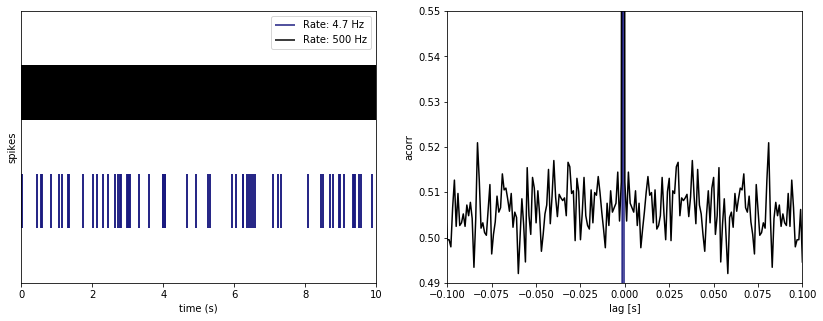

In [10]:
dt = 0.001   # time step in seconds
t  = [0, 10] # time interval (length) of spike train to generate   

# generate a poisson spike train
rate1 = 4.7 # in Hz
spk_poiss_t1 = poissonSpikeTrain(rate1, dt, t)
print(f" {len(spk_poiss_t1)} spikes generated in {np.diff(t)[0]} s at a rate of {rate1} Hz")

# poisson spike train auto correlation function
bin_size = 0.001 # in s
max_t    = 1 # in s
ac_poiss1, bin_edges = autocorr(spk_poiss_t1, bin_size, max_t) # calculate the autocorrelation function

# generate another poisson spike train
rate2 = 500 # in Hz
spk_poiss_t2 = poissonSpikeTrain(rate2, dt, t)  
print(f" {len(spk_poiss_t2)} spikes generated in {np.diff(t)[0]} s at a rate of {rate2} Hz")

ac_poiss2, bin_edges = autocorr(spk_poiss_t2, bin_size, max_t) # calculate the autocorrelation function


# Plot the data
h_fig, h_ax = plt.subplots(ncols = 2, nrows = 1)
h_ax[0].vlines([spk_poiss_t1, spk_poiss_t1],-1, -0.5, Color = [0.1, 0.1, 0.5], label=f"Rate: {rate1} Hz") # note, plots all spikes in one command
h_ax[0].vlines([spk_poiss_t2, spk_poiss_t2],0, 0.5, Color = [0, 0, 0], label=f"Rate: {rate2} Hz")
h_ax[0].set_ylim([-1.5, 1.0])
h_ax[0].set_xlim([0, 10])
h_ax[0].set_yticks([])
h_ax[0].set_ylabel('spikes')
h_ax[0].set_xlabel('time (s)')

h_ax[0].legend()

h_ax[1].plot(bin_edges[:-1]-bin_size/2, ac_poiss1, Color = [0.1, 0.1, 0.5])
h_ax[1].plot(bin_edges[:-1]-bin_size/2, ac_poiss2, Color = [0, 0, 0])
ac_ax_ylim = [0.49, 0.55]
h_ax[1].set_ylim(ac_ax_ylim)
h_ax[1].set_xlim(np.array([-1, 1])*0.1)
h_ax[1].set_xlabel('lag [s]')
h_ax[1].set_ylabel('acorr')

plt.show()

##### Autocorrelation function of a real spike train
data are from a single unit recorded from the auditory cortex of an awake marmoset while the cortex was being cooled

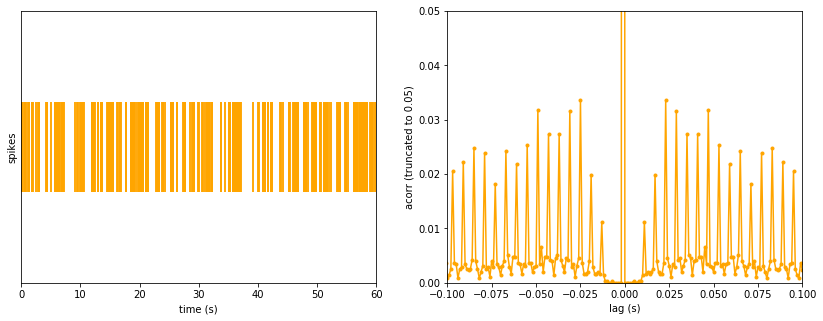

In [11]:
spike_times = np.loadtxt('data' + '/' + 'M8T_Spont_Hole001_Track006_Depth01360_Date09-02-10_001_spike_times.txt', delimiter = ',') 

temp_And_times =  np.loadtxt('data' + '/' + 'M8T_Spont_Hole001_Track006_Depth01360_Date09-02-10_001_temperature.txt',delimiter = ',') 

spike_times_s = spike_times * 60

# real spike train auto correlation function
bin_size = 0.001 # in s
max_t    = 1 # in s
ac_spike, bin_edges = autocorr(spike_times_s, bin_size, max_t) # calculate the autocorrelation function
    
# Plot the data
h_fig, h_ax = plt.subplots(ncols = 2, nrows = 1)
h_ax[0].vlines([spike_times_s, spike_times_s],-1, -0.5, Color = 'orange') # note, plots all spikes in one command
h_ax[0].set_ylim([-1.5, 0])
h_ax[0].set_xlim([0, 60])
h_ax[0].set_yticks([])
h_ax[0].set_ylabel('spikes')
h_ax[0].set_xlabel('time (s)')

h_ax[1].plot(bin_edges[:-1]-bin_size/2, ac_spike, marker='.', color = 'orange')

ac_ax_ylim = [0, 0.05]
h_ax[1].set_ylim(ac_ax_ylim)
h_ax[1].set_xlim(np.array([-1, 1])*0.1)

h_ax[1].set_xlabel('lag (s)')
h_ax[1].set_ylabel(f"acorr (truncated to {ac_ax_ylim[1]})")

plt.show()

correct the autocorrelation function to normalize such that it gives the conditional firing rate

##### Interspike interval distribution

In [12]:
def interspikeIntervalDist(spike_t, binsize, max_t, normed = True):
    # calculate an estimate of the interspike interval distribution
    
    xbin_edges = np.arange(0, max_t+binsize, binsize) # last bin includes the edge
    ISI = np.zeros(len(xbin_edges)-1)
    
    isi_all = np.diff(spike_t)
      
    ISI = np.histogram(isi_all, bins = xbin_edges)[0] # note that hist() puts all spikes outside the bin centers in the first and last bins! delete later.
    
    if normed:
        ISI = ISI / (len(spike_t)) / binsize # to yield th conditional probability density (spikes/s)
    
    return ISI, xbin_edges

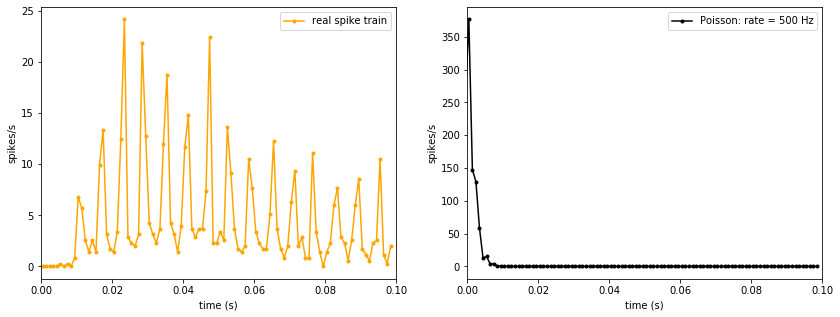

In [13]:
# calculate the interspike interval distribution of an actual spike train

# basic variables
bin_size = 0.001 # in s
max_t    = 0.1 # in s

# real spike train ISI
ISI_real, bin_edges = interspikeIntervalDist(spike_times_s, bin_size, max_t)

# do the same for a poisson spike train
ISI_poisson, bin_edges = interspikeIntervalDist(spk_poiss_t2, bin_size, max_t)

# Plot the data
h_fig, h_ax = plt.subplots(ncols = 2, nrows = 1)
h_ax[0].plot(bin_edges[:-1]-bin_size/2, ISI_real, marker = '.', Color = 'orange', label=f"real spike train")
h_ax[0].set_xlim([0, max_t])
h_ax[0].set_ylabel('spikes/s')
h_ax[0].set_xlabel('time (s)')

h_ax[0].legend()

h_ax[1].plot(bin_edges[:-1]-bin_size/2, ISI_poisson, marker = '.', Color = 'black', label=f"Poisson: rate = {rate2} Hz")
h_ax[1].set_xlim([0, max_t])
h_ax[1].set_ylabel('spikes/s')
h_ax[1].set_xlabel('time (s)')

h_ax[1].legend()

plt.show()

##### Calculate the interspike interval in steps of 30 seconds

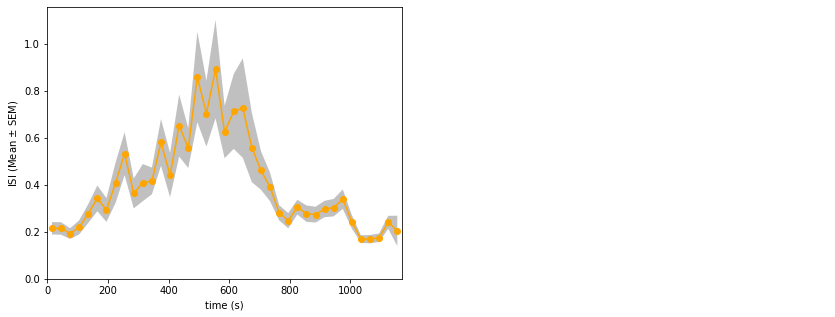

In [14]:
# basic variables
step_size = 30


# analyze firing pattern
Un1_ISI = np.diff(spike_times_s) # ISI given in seconds
Un1_ISI_ts = spike_times_s[:-1:]+Un1_ISI/2; # timestamp of the ISI as the middle between 2 successive spikes

t_steps = np.arange(0, max(spike_times_s)+step_size, step_size) # average in 30 second steps
Un1_t_step_ISIstat = [] # prepare a place holder for ISI statistics (mean, std)
for idx_t_step, t_step in enumerate(t_steps):
    if idx_t_step == len(t_steps)-1:
        break
        
    Un1_ISI_twin = Un1_ISI[ np.all((Un1_ISI_ts > t_step, Un1_ISI_ts <= t_steps[idx_t_step+1]),axis = 0)]
    
    Un1_t_step_ISIstat.append([np.nanmean(Un1_ISI_twin), np.nanstd(Un1_ISI_twin), np.nanstd(Un1_ISI_twin)/np.sqrt(Un1_ISI_twin.shape[0])])

# convert the ISI statistics list into a numpy array
Un1_t_step_ISIstat = np.array(Un1_t_step_ISIstat)

h_fig, h_ax = plt.subplots(ncols = 2, nrows = 1)
h_ax[0].plot(t_steps[:-1:]+step_size/2, Un1_t_step_ISIstat[:,0], Color = 'orange', marker = 'o')

h_ax[0].fill_between(t_steps[:-1:]+step_size/2, Un1_t_step_ISIstat[:,0] -  Un1_t_step_ISIstat[:,2], Un1_t_step_ISIstat[:,0] +  Un1_t_step_ISIstat[:,2], 
                     facecolor='silver')
h_ax[0].set_ylabel('ISI (Mean $\pm$ SEM)')
h_ax[0].set_xlabel('time (s)') 
h_ax[0].set_xlim([-1, max(t_steps)+1])
h_ax[0].set_ylim([0, max(Un1_t_step_ISIstat[:,0] +  Un1_t_step_ISIstat[:,2])*1.05])

h_ax[1].axis('off')

plt.show()

Poisson spike trains as defined above do not have a refractory period. Therefore, the autocorrelation function does not go down to zero in a narrow time window around a spike.

##### Summary

Github repository of the lecture: https://github.com/JeschkeM/hello-world